# Transformers

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import re
import unicodedata
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time

2024-04-19 14:27:08.360506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 14:27:08.360536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 14:27:08.361403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def unicode_to_ascii(w):
    return ''.join([x for x in unicodedata.normalize('NFD', w) if unicodedata.category(x) != 'Mn'])
 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub('([?!.(),¿])', r' \1', w)
    w = re.sub('\s{2,}', ' ', w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w) # This replaces everything with space
    w = w.rstrip().strip()
    return '<start> ' + w + ' <end>' 

In [3]:
def create_dataset(file_path, num_examples=None):
    spa_en = []
    cnt = 0
    with open(file_path, 'r') as file:
        for line in file.readlines():
            if num_examples is not None and cnt >= num_examples: break
            line = line.split('\t')[:2]
            spa_en.append([preprocess_sentence(line[0]), preprocess_sentence(line[1])])
            cnt += 1
    return zip(*spa_en)

In [4]:
FILE_PATH =  './temp/spa-eng/spa.txt'
en, sp = create_dataset(FILE_PATH)
print(en[-1])
print(sp[-1])

<start> one day , i woke up to find that god had put hair on my face . i shaved it off . the next day , i found that god had put it back on my face , so i shaved it off again . on the third day , when i found that god had put hair back on my face again , i decided to let god have his way . that s why i have a beard . <end>
<start> un dia , me desperte y vi que dios me habia puesto pelo en la cara . me lo afeite . al dia siguiente , vi que dios me lo habia vuelto a poner en la cara , asi que me lo afeite otra vez . al tercer dia , cuando vi que dios me habia puesto pelo en la cara de nuevo , decidi que dios se saliera con la suya . por eso tengo barba . <end>


In [5]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [6]:
def tokenize(tensor):
    lang_tokenizer = Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(tensor)
    tensor = lang_tokenizer.texts_to_sequences(tensor)
    tensor = pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [7]:
def load_dataset(file_name, num_examples=None):
    src_lang, targ_lang = create_dataset(file_name, num_examples)
    src_tensor, src_tokenizer = tokenize(src_lang)
    targ_tensor, targ_tokenizer = tokenize(targ_lang)
    return src_tensor, targ_tensor, src_tokenizer, targ_tokenizer

## Loading the dataset

In [8]:
NUM_SAMPLES = 100_000
src_tensor, targ_tensor, src_tokenizer, targ_tokenizer = load_dataset(FILE_PATH, num_examples=NUM_SAMPLES)

MAX_SRC_LENGTH, MAX_TARGET_LENGTH = max_length(src_tensor), max_length(targ_tensor)
print(f'Maximum length of English sentence is {MAX_SRC_LENGTH}\nMaximum length for spanish sentence is {MAX_TARGET_LENGTH}')

Maximum length of English sentence is 15
Maximum length for spanish sentence is 22


In [9]:
src_train, src_val, targ_train, targ_val = train_test_split(src_tensor, targ_tensor, test_size=0.2)

print('Source Train shape:', src_train.shape)
print('Source Validation shape:', src_val.shape)
print('Target Train shape:', targ_train.shape)
print('Target Validation shape:', targ_val.shape)

Source Train shape: (80000, 15)
Source Validation shape: (20000, 15)
Target Train shape: (80000, 22)
Target Validation shape: (20000, 22)


In [10]:
def ids_to_text(ids, lang):
    return ' '.join(lang.index_word[i] for i in ids if i != 0)

In [11]:
i = 3000
print('Training Example (English)')
print(ids_to_text(src_train[i], src_tokenizer))

print('Training Example (Spanish)')
print(ids_to_text(targ_train[i], targ_tokenizer))

Training Example (English)
<start> tell us what you want to do . <end>
Training Example (Spanish)
<start> dinos que quieres hacer . <end>


## Create the pipeline

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
VOCAB_SRC_SIZE = len(src_tokenizer.index_word) + 1
VOCAB_TARG_SIZE = len(targ_tokenizer.index_word) + 1
BATCH_SIZE = 64
STEPS_PER_EPOCH = len(src_train) // BATCH_SIZE
BUFFER_SIZE = len(src_train)

train_ds = tf.data.Dataset.from_tensor_slices((src_train, targ_train))
train_ds = train_ds.shuffle(BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((src_val, targ_val))
test_ds = test_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
test_ds = test_ds.prefetch(AUTOTUNE)

In [13]:
example_train_source, example_train_target = next(iter(train_ds))
print('Example Train Source:', example_train_source.shape)
print('Example Train Target:', example_train_target.shape)

Example Train Source: (64, 15)
Example Train Target: (64, 22)


## Define the model

In [14]:
from keras.layers import Layer, Dense, Dropout, LayerNormalization, Embedding, Add, Activation, Input
from keras.models import Model

### Self-Attention
Attention is calculated with the formula below
$$
\begin{equation}
    \text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^\top}{\sqrt{d_k}})V
\end{equation}
$$

In [15]:
class Attention(Layer):
    def __init__(self, dropout_rate=0, use_scale=False):
        super(Attention, self).__init__()

        self.use_scale = use_scale
        self.dropout_rate = dropout_rate
        if dropout_rate > 0:
            self.dropout = Dropout(dropout_rate, name='dropout')


    def build(self, input_shapes):
        self.scale = None
        if self.use_scale:
            self.scale = self.add_weight(
                name='scale',
                shape=(),
                initializer='ones',
                dtype=tf.float32,
                trainable=True
            )
        self.built = True
        

    def get_config(self):
        base_config = super(Attention, self).get_config()
        config = {
            'dropout_rate':self.dropout_rate,
            'use_scale':self.use_scale
        }
        return {**base_config, **config}
        

    def call(self, inputs, *, 
             return_attention_scores=False, 
             use_causal_mask=False, 
             training=False):
        """
        Args:
            Inputs has the shape of (batch_size, nq, d_model)
            use_causal_mask(opt.):
                Given that queries have the shape [batch_size, nq, d_model] where nq is the number of queries,
                when we are attending to query "i" we should not consider queries "j" where "j > i". For example
                let's say we are generating text, since we shall not see the subsequent queries in the training phase
                and we won't have any subsequent queries in the prediction phase, we should not attend to the subsequent
                queries by zeroing out their attention scores having the shape of [batch_size, nq, nv] where nv is the
                number of number of values (or keys)

        """

        # query has the shape [batch_size, tq, dk] where tq is the number of queries
        # key has the shape [batch_size, tv, dk] where tv is the number of keys
        # value has the shape [batch_size, tv, dv] wehre tv is the number of values 
        query, key, value = inputs

        Tq = tf.shape(query)[1]
        Tv = tf.shape(key)[1]

        # QK will have the shape of (batch_size, Tq, Tv)
        # This is the MatMul left part of the Figure2 from the paper "Attention is all you need"
        QK = tf.matmul(query, key, transpose_b=True)

        if self.scale is not None:
            scaled = QK * self.scale
        else: scaled = QK
            

        if use_causal_mask:
            causal_mask_shape = (Tq, Tv)
            causal_mask = tf.linalg.band_part(tf.ones(shape=causal_mask_shape), -1, 0)
            scaled = scaled - 1e9 * (1 - causal_mask)
            

        # Softmax of the result is calculated, this is also known as "attention scores"
        attention_scores = tf.nn.softmax(scaled, axis=-1)
        
        if self.dropout_rate > 0:
            attention_scores = self.dropout(attention_scores, training=training)

        # Calculate the matmul with V and the resulting shape would be (batch_size, tv, dv)
        # attention output has the shape (batch_size, tq, dv)
        attention_output = tf.matmul(attention_scores, value)

        if not return_attention_scores:
            return attention_output
        
        return attention_output, attention_scores

In [16]:
# Test Attention
# This hyperparameters are invalid; (only for test purposes)
d_model = 14

dk = 50
dv = 55

batch_size = 64
tq = 10
tv = 9

# These weights are applied in MultiHeadAttention Layer but has been added here for testing purposes
wq = Dense(units=dk)
wk = Dense(units=dk)
wv = Dense(units=dv)


q = np.random.rand(batch_size, tq, d_model)
k = np.random.rand(batch_size, tv, d_model)
v = np.random.rand(batch_size, tv, d_model)

q = wq(q)
print('q shape', q.shape)

k = wk(k)
print('key shape', k.shape)

v = wv(v)
print('value shape', v.shape)

attention = Attention(dropout_rate=0.5)
outputs, scores = attention([q, k, v], use_causal_mask=True, return_attention_scores=True)
print('attention scores', scores.shape)
print(scores[0, 3, :])
print('attention outputs\' shape', outputs.shape)
print('attention outputs', outputs[0, 3, :])

q shape (64, 10, 50)
key shape (64, 9, 50)
value shape (64, 9, 55)
attention scores (64, 10, 9)
tf.Tensor(
[0.15712121 0.44209054 0.2738526  0.12693563 0.         0.
 0.         0.         0.        ], shape=(9,), dtype=float32)
attention outputs' shape (64, 10, 55)
attention outputs tf.Tensor(
[-0.15378106 -0.17477275 -0.43831834  0.00712101 -0.00312345  0.50953513
 -0.13907008 -0.00212041  0.40580216 -0.73303914 -0.05059539 -0.09579656
  0.36663908  0.05647525  0.04788486 -0.32089776  0.3345108  -0.7154118
 -0.10069063 -0.15515542 -0.00349455  0.07534441  0.03626923 -0.48694047
  0.6681713  -0.21413423 -0.2389604   0.00289998 -0.39761895 -0.02599667
  0.07329989 -0.5431054  -0.3541438   0.12903804  0.00647693  0.00150463
  0.12738243 -0.2070067  -0.40533742 -0.34200937 -0.39612633 -0.24990225
 -0.2377383   0.3697941   0.278486   -0.397109    0.00446686 -0.1816128
 -0.05785983  0.19765086 -0.32452416 -0.2512303  -0.04491947 -0.24228837
 -0.27447844], shape=(55,), dtype=float32)


### Multi-Head Attention

In [57]:
class MultiHeadAttention(Layer):
    def __init__(self, num_heads, key_dim, value_dim=None, dropout=0.0, use_bias=True):
        super(MultiHeadAttention, self).__init__()
        self.dropout_rate = dropout
        self.num_heads = num_heads
        self.use_bias = use_bias
        # This is the same as d_k in the paper and dk explained above for Attention Layer
        self.key_dim = key_dim
        # This is the same as d_v in the paper and dv explained above for Attention Layer
        self.value_dim = key_dim if value_dim is None else value_dim

        # We should define some transformations to project d_model to dk, dk, dv for query, key and value respectively
        self.WQ = Dense(units=key_dim, use_bias=use_bias)
        self.WK = Dense(units=key_dim, use_bias=use_bias)
        self.WV = Dense(units=self.value_dim, use_bias=use_bias)

        if self.dropout_rate > 0.0:
            self.dropout = Dropout(self.dropout_rate, name='dropout')

        # cache 1.0/sqrt(key_dim)
        self.scale = 1.0 / tf.sqrt(key_dim * 1.0)


    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.key_dim % self.num_heads == 0, f"key_dim={self.key_dim} % num_heads={self.num_heads} != 0"
        assert self.value_dim % self.num_heads == 0, f"value_dim={self.value_dim} % num_heads={self.num_heads} != 0"
        self.WO = Dense(units=self.d_model, use_bias=self.use_bias)
        self.built=True


    def split_heads(self, x):
        # x has the shape [batch_size, seq_len, d_model]
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        x = tf.reshape(x, shape=(batch_size, seq_len, self.num_heads, -1))
        # transpose to get [batch_size, num_heads, seq_len, depth]
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return x


    def call(self, query, key, value, *, use_causal_mask=False, return_attention_scores=False, training=False):
        batch_size = tf.shape(query)[0]
        
        # query has the shape [batch_size, nq, d_model]
        # key has the shape [batch_size, nk, d_model]
        # value has the shape [batch_size, nk, d_model]

        # q = [batch_size, nq, dk]
        q = self.WQ(query)
        # k = [batch_size, nk, dk]
        k = self.WK(key)
        # v = [batch_size, nk, dv]
        v = self.WV(value)

        # q has the shape [batch_size, num_heads, nq, dk / num_heads]
        q = self.split_heads(q)
        # k has the shape [batch_size, num_heads, nk, dk / num_heads]
        k = self.split_heads(k)
        # has the shape [batch_size, num_heads, nk, dv / num_heads]
        v = self.split_heads(v)
        

        # attention_outputs = [batch_size, num_heads, Tq, dv / num_heads]
        # attention_scores = [batch_size, num_heads, Tq, Tk]
        attention_outputs, attention_scores = self.scaled_dot_product_attention(q, k, v,
                                                                                use_causal_mask=use_causal_mask,
                                                                                training=training)

        # concat_attention = [batch_size, Tq, num_heads * dv]
        attention_outputs = tf.transpose(attention_outputs, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention_outputs, shape=(batch_size, -1, self.value_dim))
        # outputs = [batch_size, Tq, d_model]
        outputs = self.WO(concat_attention)

        if return_attention_scores:
            return outputs, attention_scores

        return outputs


    def scaled_dot_product_attention(self, q, k, v, use_causal_mask=False, training=False):
        num_head = tf.shape(q)[1]
        Tq = tf.shape(q)[2]
        Tk = tf.shape(k)[2]
        # q has the shape [batch_size, num_head, Tq, dk / num_heads]
        # k has the shape [batch_size, num_head, Tk, dk / num_heads]
        # dk is key_dim
        # So the resulting qk will have the shape [batch_size, num_head, Tq, Tk]
        qk = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2]))
        scaled = qk * self.scale
        
        if use_causal_mask:
            causal_mask_shape = (num_head, Tq, Tk)
            causal_mask = tf.linalg.band_part(tf.ones(shape=causal_mask_shape), -1, 0)
            scaled = scaled - 1e9 * (1 - causal_mask)
            
        attention_scores = tf.nn.softmax(scaled, axis=-1)

        if self.dropout_rate > 0.0:
            attention_scores = self.dropout(attention_scores, training=training)

        # v has the shape [batch_size, num_heads, Tk, dv / num_heads]
        # attention_scoress has the shape [batch_size, num_heads, Tq, Tk]
        # The resulting attention_outputs has the shape [batch_size, num_heads, Tq, dv / num_heads] 
        # dv is value_dim
        attention_outputs = tf.matmul(attention_scores, v)
        return attention_outputs, attention_scores    


    def get_config(self):
        base_config = super(MultiHeadAttention, self).get_config()
        config = {
            'num_heads':self.num_heads,
            'key_dim':self.key_dim,
            'value_dim':self.value_dim,
            'dropout_rate':self.dropout_rate,
            'use_bias':self.use_bias
        }

        return {**base_config, **config}

In [58]:
# Test Multi-Head Attention
# This hyperparameters are invalid; (only for test purposes)
d_model = 16

dk = 32
dv = 128

batch_size = 64
tq = 9
tv = 8

q = np.random.rand(batch_size, tq, d_model)
k = np.random.rand(batch_size, tv, d_model)
v = np.random.rand(batch_size, tv, d_model)

mha = MultiHeadAttention(num_heads=8, key_dim=dk)
outputs, scores = mha(query=q, key=k, value=v, use_causal_mask=True, return_attention_scores=True)
print('attention scores', scores.shape)
print(scores[0, 3, :])
print('attention outputs\' shape', outputs.shape)
print('attention outputs', outputs[0, 3, :])

attention scores (64, 8, 9, 8)
tf.Tensor(
[[1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.50400895 0.49599108 0.         0.         0.         0.
  0.         0.        ]
 [0.32776552 0.3144597  0.35777473 0.         0.         0.
  0.         0.        ]
 [0.24912846 0.24506362 0.2586271  0.24718085 0.         0.
  0.         0.        ]
 [0.20095961 0.20129511 0.20762295 0.18966253 0.20045987 0.
  0.         0.        ]
 [0.16674995 0.16821446 0.16550328 0.16079544 0.16824117 0.17049572
  0.         0.        ]
 [0.14237346 0.14060894 0.14451465 0.14202225 0.14413713 0.14408775
  0.1422558  0.        ]
 [0.12460912 0.12391213 0.12611422 0.12657101 0.12318241 0.12705772
  0.12304392 0.12550944]
 [0.12418209 0.12230739 0.1284542  0.1282988  0.12124489 0.12816842
  0.12180787 0.12553637]], shape=(9, 8), dtype=float32)
attention outputs' shape (64, 9, 16)
attention outputs tf.Tensor(
[ 0.23664808 -0.20060039 -0.66841215  0.34204724  0.90257126  0.

In [59]:
# Test Multi-Head Attention
# This hyperparameters are invalid; (only for test purposes)
d_model = 16

dk = 32
dv = 128

batch_size = 64
tq = 9
tv = 8

q = np.random.rand(batch_size, tq, d_model)
k = np.random.rand(batch_size, tv, d_model)
v = np.random.rand(batch_size, tv, d_model)

mha = MultiHeadAttention(num_heads=8, key_dim=dk)
outputs, scores = mha(query=q, key=k, value=v, use_causal_mask=True, return_attention_scores=True)
print('attention scores', scores.shape)
print(scores[0, 3, :])
print('attention outputs\' shape', outputs.shape)
print('attention outputs', outputs[0, 3, :])

attention scores (64, 8, 9, 8)
tf.Tensor(
[[1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.49043748 0.50956255 0.         0.         0.         0.
  0.         0.        ]
 [0.33384007 0.33142382 0.33473614 0.         0.         0.
  0.         0.        ]
 [0.24801917 0.25754002 0.2402883  0.2541525  0.         0.
  0.         0.        ]
 [0.19908597 0.2065854  0.18917984 0.20398088 0.20116793 0.
  0.         0.        ]
 [0.16393855 0.18169999 0.1545657  0.17293684 0.16767834 0.15918055
  0.         0.        ]
 [0.14275849 0.15194444 0.1316448  0.1468562  0.14668143 0.13966033
  0.14045435 0.        ]
 [0.12460391 0.1292507  0.12369926 0.1279096  0.12273814 0.12287076
  0.12479835 0.12412923]
 [0.12386139 0.13198854 0.12018606 0.1300583  0.12295138 0.12365565
  0.12656933 0.12072932]], shape=(9, 8), dtype=float32)
attention outputs' shape (64, 9, 16)
attention outputs tf.Tensor(
[-0.46875706  0.39418525  0.43821317 -0.24061157  0.07841872  0.

### Embedding and positional encoding layer

![Positional Embedding](./Images/012_Positional_embedding.png)

$$
\begin{align}
    &PE(pos, 2i) = sin(\frac{pos}{10000^{\frac{2i}{d}}})\\
    &PE(pos, 2i + 1) = cos(\frac{pos}{10000^{\frac{2i + 1}{d}}})
\end{align}
$$

In [60]:
def positional_encoding(length, depth):
    depth = depth / 2

    positions = tf.range(0, length, dtype='float32')[..., None]
    depths = tf.range(depth)[None, ...] / depth

    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates

    pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)
    
    return pos_encoding

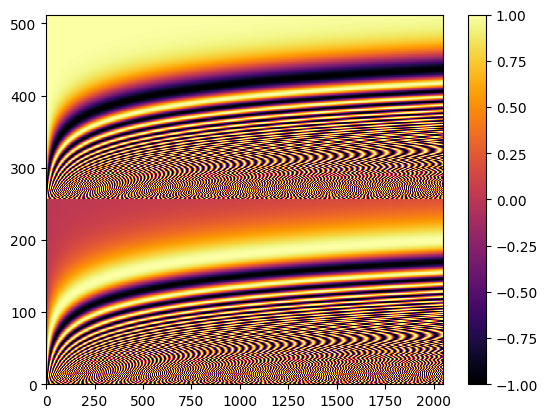

In [61]:
pos_enc = positional_encoding(2048, 512)

plt.pcolormesh(pos_enc.numpy().T, cmap='inferno');
plt.colorbar();

In [62]:
class PositionalEmbedding(Layer):
    def __init__(self, vocab_size, d_model, max_position=2048):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = Embedding(input_dim=vocab_size, output_dim=d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(max_position, d_model)


    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    
    def call(self, inputs):
        length = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [63]:
en_emb = PositionalEmbedding(VOCAB_SRC_SIZE, d_model=512)
sp_emb = PositionalEmbedding(VOCAB_TARG_SIZE, d_model=512)

en_example_emb = en_emb(example_train_source)
sp_example_emb = sp_emb(example_train_target)

### Base Attention

![Base Attention](./Images/012_base_attention.png)

In [64]:
class BaseAttention(Layer):
    def __init__(self, **kwargs):
        super(BaseAttention, self).__init__()
        self.mha = MultiHeadAttention(**kwargs)
        self.add = Add(name='add')
        self.layernorm = LayerNormalization(name='norm')

### Self Attention
![Self Attention](./Images/012_global_self_attention.png)

In [65]:
class SelfAttention(BaseAttention):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)


    def call(self, inputs, training=False):
        # inputs = [batch_size, seq_len, d_model]
        # outputs = [batch_size, seq_len, d_model]
        outputs = self.mha(query=inputs,
                           key=inputs,
                           value=inputs,
                           training=training)

        # adds residual connection
        outputs = self.add([inputs, outputs])
        outputs = self.layernorm(outputs)
        return outputs

![Masked attention](./Images/012_Masked_attention.png)

In [66]:
class MaskedAttention(BaseAttention):
    def __init__(self, **kwargs):
        super(MaskedAttention, self).__init__(**kwargs)

    
    def call(self, inputs, training=False):
        # inputs = [batch_size, seq_len, d_model]
        # outputs = [batch_size, seq_len, d_model]
        outputs = self.mha(query=inputs, 
                           key=inputs,
                           value=inputs,
                           use_causal_mask=True,
                           training=training)


        # Adds residual connection
        outputs = self.add([inputs, outputs])
        outputs = self.layernorm(outputs)

        return outputs

![Feed forward](./Images/012_FeedForward.png)

In [67]:
class FeedForward(Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super(FeedForward, self).__init__()

        # Naming conventions are according to the paper [Attention is all you need]
        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        if dropout_rate > 0.0:
            self.dropout = Dropout(dropout_rate, name='dropout')

        self.W1 = Dense(units=dff, activation='relu')
        self.W2 = Dense(units=d_model, activation='linear')
        self.add = Add(name='add')
        self.layernorm = LayerNormalization(name='layernorm')


    def call(self, inputs, training=False):
        # inputs = [Batch_size, nq, d_model]
        # resuting x = [Batch_size, nq, dff]
        x = self.W1(inputs)
        # resulting x = [Batch_size, nq, d_model]
        x = self.W2(x)
        if self.dropout_rate > 0.0:
            x = self.dropout(x, training=training)
        # adds residual connection
        x = self.add([inputs, x])
        x = self.layernorm(x)
        return x

![Cross attention](./Images/012_cross_attention.png)

In [68]:
class CrossAttention(BaseAttention):
    def __init__(self, **kwargs):
        super(CrossAttention, self).__init__(**kwargs)


    def call(self, query, context, training=False):
        # query = [batch_size, dec_seq, d_model]
        # context = [batch_size, enc_seq, d_model]
        # outputs = [batch_size, dec_seq, d_model]
        # attention_scores = [batch_size, num_heads, dec_seq, enc_seq]
        outputs, attention_scores = self.mha(query=query, 
                                             key=context, 
                                             value=context, 
                                             training=training, 
                                             return_attention_scores=True)

        # cache the attention scores
        self.attention_scores = attention_scores

        # add residual connection
        outputs = self.add([query, outputs])
        outputs = self.layernorm(outputs)

        return outputs

### Encoder

#### Encoder Layer
![Encoder layer](./Images/012_Encoder.png)

In [69]:
class EncoderLayer(Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.self_attention = SelfAttention(num_heads=num_heads,
                                            key_dim=d_model,
                                            dropout=dropout_rate)
        
        self.ffn = FeedForward(d_model=d_model, 
                               dff=dff,
                               dropout_rate=dropout_rate)

    def call(self, inputs, training=False):
        # inputs = [batch_size, enc_seq, d_model]
        # outputs = [batch_size, enc_seq, d_model]
        outputs = self.self_attention(inputs, training=training)
        # outputs = [batch_size, enc_seq, d_model]
        outputs = self.ffn(outputs, training=training)
        return outputs

#### Encoder
![Encoder](./Images/012_full_encoder.png)

In [70]:
class Encoder(Layer):
    def __init__(self, *, d_model, num_heads, dff, N, vocab_size, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.N = N
        self.dropout_rate = dropout_rate

        self.positional_embedding = PositionalEmbedding(vocab_size=vocab_size, 
                                                        d_model=d_model)

        self.stacks = [EncoderLayer(d_model=d_model, 
                                    num_heads=num_heads, 
                                    dff=dff, 
                                    dropout_rate=dropout_rate) for _ in range(N)]

        if dropout_rate > 0.0:
            self.dropout = Dropout(dropout_rate, name='dropout')


    def call(self, inputs, training=False):
        # inputs = [batch_size, seq_len]
        # x = [batch_size, seq_len, d_model]
        x = self.positional_embedding(inputs)
        if self.dropout_rate > 0.0:
            x = self.dropout(x, training=training)

        for i in range(self.N):
            x = self.stacks[i](x, training=training)

        # returns [batch_size, seq_len, d_model]
        return x

In [71]:
# test Encoder
sample_encoder = Encoder(d_model=512, num_heads=8, dff=2048, N=6, vocab_size=VOCAB_SRC_SIZE)
print('input shape', example_train_source.shape)
encoder_outputs = sample_encoder(example_train_source)
print('output shape', encoder_outputs.shape)

input shape (64, 15)
output shape (64, 15, 512)


### Decoder
#### Decoder Layer
![Decoder layer](./Images/012_decoder.png)

In [72]:
class DecoderLayer(Layer):
    def __init__(self, *, num_heads, d_model, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.dff = dff


        self.masked_attention = MaskedAttention(num_heads=num_heads, 
                                                key_dim=d_model, 
                                                dropout=dropout_rate)

        self.cross_attention = CrossAttention(num_heads=num_heads, 
                                              key_dim=d_model, 
                                              dropout=dropout_rate)

        self.ffn = FeedForward(d_model=d_model, 
                               dff=dff, 
                               dropout_rate=dropout_rate)


    def call(self, inputs, context, training=False):
        # inputs = [batch_size, dec_seq_len, ,d_model]
        # context = [batch_size, enc_seq_len, d_model]

        # masked_attention_outputs =  [batch_size, dec_seq_len, d_model]
        masked_attention_outputs = self.masked_attention(inputs, training=training)

        # outputs = [batch_size, dec_seq_len, d_model]
        outputs = self.cross_attention(masked_attention_outputs, context, training=training)
        
        # cache the attention scores = [batch_size, num_heads, dec_seq_len, enc_seq_len]
        self.last_attention_scores = self.cross_attention.attention_scores

        # outputs shape is [batch_size, dec_seq_len, d_model]
        outputs = self.ffn(outputs, training=training)
        return outputs

#### Decoder
![Decoder](./Images/012_Full_decoder.png)

In [73]:
class Decoder(Layer):
    def __init__(self, *, num_heads, d_model, N, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.dff = dff
        self.vocab_size = vocab_size
        self.dropout_rate = dropout_rate
        self.N = N


        self.positional_embedding = PositionalEmbedding(vocab_size=vocab_size, 
                                                        d_model=d_model)

        self.stacks = [DecoderLayer(num_heads=num_heads,
                                    d_model=d_model, 
                                    dff=dff,
                                    dropout_rate=dropout_rate) for _ in range(N)]

        if dropout_rate > 0.0:
            self.dropout = Dropout(dropout_rate, name='dropout')


    def call(self, inputs, context, training=False):
        # inputs = [batch_size, dec_seq_len]
        # context = [batch_size, enc_seq_len, d_model]

        # x = [batch_size, dec_seq_len, d_model]
        x = self.positional_embedding(inputs)
        if self.dropout_rate > 0.0:
            x = self.dropout(x, training=training)

        # result of this for loop is x = [batch_size, dec_seq_len, d_model]
        for i in range(self.N):
            x = self.stacks[i](x, context=context, training=training)

        # cache the last attention score for plotting
        self.last_attention_scores = self.stacks[-1].last_attention_scores
        
        return x

In [74]:
sample_decoder = Decoder(num_heads=8, d_model=512, N=6, dff=2048, vocab_size=VOCAB_TARG_SIZE)
print('Input shape', example_train_target.shape)
decoder_output = sample_decoder(example_train_target, encoder_outputs)
print('Output shape', decoder_output.shape)

Input shape (64, 22)
Output shape (64, 22, 512)


### Transformer
![Transformer](./Images/012_transformer.png)

In [75]:
class Transformer(Model):
    def __init__(self, *, 
                 d_model, 
                 num_heads, 
                 N, 
                 dff, 
                 source_vocab_size, 
                 target_vocab_size, 
                 dropout_rate=0.1):
        
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.N = N
        self.dff = dff
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        self.dropout_rate = dropout_rate

        self.encoder = Encoder(d_model=d_model, 
                               num_heads=num_heads, 
                               N=N,
                               dff=dff, 
                               vocab_size=source_vocab_size, 
                               dropout_rate=dropout_rate)

        
        self.decoder = Decoder(d_model=d_model, 
                               num_heads=num_heads, 
                               N=N, 
                               dff=dff, 
                               vocab_size=target_vocab_size, 
                               dropout_rate=dropout_rate)

        
        self.classifier = Dense(units=target_vocab_size, name='classifier')


    def build(self, input_shapes):
        encoder_input_shape = input_shapes[0]
        decoder_input_shape = input_shapes[1]
        encoder_input = Input(shape=encoder_input_shape)
        decoder_input = Input(shape=decoder_input_shape)
        self.call(encoder_input, decoder_input)
        self.built = True


    def call(self, source, target, training=False):
        # source has the shape [batch_size, source_seq_len]
        # target has the shape [batch_size, target_seq_len]

        # context has the shape [batch_size, source_seq_len, d_model]
        context = self.encoder(source, training=training)

        # x has the shape [batch_size, target_seq_len, d_model]
        x = self.decoder(target, context, training=training)

        # logits has the shape [batch_size, target_seq_len, target_vocab_size]
        logits = self.classifier(x, training=training)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [76]:
NUM_HEADS = 8
D_MODEL = 128
N = 4
DFF = 512
DROPOUT_RATE = 0.1

transformer = Transformer(d_model=D_MODEL, 
                          num_heads=NUM_HEADS, 
                          N=N, 
                          dff=DFF, 
                          source_vocab_size=VOCAB_SRC_SIZE, 
                          target_vocab_size=VOCAB_TARG_SIZE, 
                          dropout_rate=DROPOUT_RATE)

transformer.build(input_shapes=[(MAX_SRC_LENGTH, ), (MAX_TARGET_LENGTH)])
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         (None, 15, 128)           2092544   
                                                                 
 decoder_3 (Decoder)         (None, 22, 128)           3678208   
                                                                 
 classifier (Dense)          (None, 22, 20468)         2640372   
                                                                 
Total params: 8411124 (32.09 MB)
Trainable params: 8411124 (32.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
